In [1]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import time
import pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split

# Clustering
from sklearn.datasets import make_biclusters, make_checkerboard, make_classification
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralCoclustering, SpectralBiclustering
from sklearn.metrics import consensus_score

# Corr
from scipy.stats import spearmanr, pearsonr
from numpy import corrcoef

# Utils
file_path = os.getcwd()  # os.path.dirname(os.path.relpath(__file__))
utils_path = os.path.abspath(os.path.join(file_path, '..', '..', 'utils_py'))
sys.path.append(utils_path)
import utils_all as utils

# Feature importance
pfi_path = os.path.abspath(os.path.join(file_path, '..', 'pfi'))
sys.path.append(pfi_path)
import pfi
import pfi_utils

import warnings
warnings.filterwarnings('ignore')

SEED=0

Using TensorFlow backend.


In [2]:
def create_nn_classifier(n_features, n_classes):
    # https://sebastianraschka.com/faq/docs/dropout-activation.html
    keras_model = Sequential()
    keras_model.add(Dense(units=32, activation='relu', input_shape=(n_features,)))
    keras_model.add(Dense(units=32, activation='relu'))
    # if n_classes == 2:
    #     keras_model.add(Dense(units=1, activation='sigmoid'))
    #     keras_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # elif n_classes > 2:
    
    # keras_model.add(Activation('softmax'))
    # keras_model.add(Dropout(0.2))
    # keras_model.add(Dense(units=n_classes, activation=None))
    keras_model.add(Dense(units=n_classes, activation='softmax'))
    keras_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return keras_model

In [3]:
path = 'results_aacr_tc_cor0.9_combat'
# path = 'results_aacr_tc_cor0.95_combat'
# path = 'results_aacr_tc_cor1.0_combat'
nns_fi = pd.read_csv(os.path.join(file_path, path, 'tc_nn_fi_score.csv'))
nnv_fi = pd.read_csv(os.path.join(file_path, path, 'tc_nn_fi_var.csv'))
rfs_fi = pd.read_csv(os.path.join(file_path, path, 'tc_rf_fi_score.csv'))
rfv_fi = pd.read_csv(os.path.join(file_path, path, 'tc_rf_fi_var.csv'))
rf_fi  = pd.read_csv(os.path.join(file_path, path, 'tc_rf_fi.csv'))

In [4]:
data_train = pd.read_csv(os.path.join(file_path, 'data', 'tc_data_train'), sep='\t')
data_val   = pd.read_csv(os.path.join(file_path, 'data', 'tc_data_val'), sep='\t')

### Do these groups make any sense?

In [5]:
rfv_fi[rfv_fi['n']>1]

,cols,n,imp
1,"AURKB,BIRC5,CCNA2,CCNB2,CDC20,CDC45,KIF2C,MELK...",11,0.022611
12,"BUB1B,CDK1,KIF14,KIF20A,NUSAP1,TOP2A",6,0.007652
17,"CCNB1,UBE2C",2,0.006409
326,"IKZF1,PTPRC",2,0.000906
503,"HLA-DMA,HLA-DRA",2,0.000340


In [6]:
nnv_fi[nnv_fi['n']>1]

,cols,n,imp
16,"AURKB,BIRC5,CCNA2,CCNB2,CDC20,CDC45,KIF2C,MELK...",11,0.002618
56,"BUB1B,CDK1,KIF14,KIF20A,NUSAP1,TOP2A",6,0.002126
101,"IKZF1,PTPRC",2,0.001794
278,"HLA-DMA,HLA-DRA",2,0.001304
518,"CCNB1,UBE2C",2,0.000907


### Throw away all the correlated features

In [7]:
def find_cor_cols(fi):
    # fi = fi.loc[fi['n']>1, 'cols']
    cols_to_drop = []
    for col_set in fi['cols'].tolist():
        if len(col_set.split(',')) > 1:
            # print(col_set)
            col = np.array(col_set.split(','))
            cols_to_drop.extend(col)
    return cols_to_drop

In [8]:
cols_to_drop = find_cor_cols(fi=rfv_fi)
len(cols_to_drop)

23

In [9]:
def drop_cols_from_fi(fi, cols_to_drop):
    idx = []
    for col_set in fi['cols'].tolist():
        if len(set(col_set.split(',')).intersection(cols_to_drop)) > 0:
            idx.append(False)
        else:
            idx.append(True)
    fi = fi[idx].copy()
    return fi

In [10]:
rf_fi  = drop_cols_from_fi(fi=rf_fi,  cols_to_drop=cols_to_drop)
rfv_fi = drop_cols_from_fi(fi=rfv_fi, cols_to_drop=cols_to_drop)
rfs_fi = drop_cols_from_fi(fi=rfs_fi, cols_to_drop=cols_to_drop)
nnv_fi = drop_cols_from_fi(fi=nnv_fi, cols_to_drop=cols_to_drop)
nnv_fi = drop_cols_from_fi(fi=nnv_fi, cols_to_drop=cols_to_drop)

In [11]:
data_train = data_train.drop(columns=cols_to_drop, errors='ignore')
data_val = data_val.drop(columns=cols_to_drop, errors='ignore')
print(data_train.shape)
print(data_val.shape)

(4080, 919)
(1020, 919)


In [12]:
xtr = data_train.iloc[:, 1:].copy()
ytr = data_train.iloc[:, 0].copy()
xvl = data_val.iloc[:, 1:].copy()
yvl = data_val.iloc[:, 0].copy()
features = xtr.columns
print(f'xtr.shape {xtr.shape}')
print(f'xvl.shape {xvl.shape}')
print(f'ytr.shape {ytr.shape}')
print(f'yvl.shape {yvl.shape}')

xtr.shape (4080, 918)
xvl.shape (1020, 918)
ytr.shape (4080,)
yvl.shape (1020,)


In [13]:
def acc_vs_ncols(xtr, xvl, ytr, yvl, fi):
    xtr = xtr.copy()
    xvl = xvl.copy()
    ytr = ytr.copy()
    yvl = yvl.copy()
    
    ncols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50, 100, 200, 300, 500, 700, 941]
    ss = pd.DataFrame(index=range(len(ncols)), columns=['ncols', 'RF_F1', 'NN_F1'])
    fi = fi.copy().reset_index(drop=True)
    
    for i, nc in enumerate(ncols):
        # print(nc)
        # xtr_ = xtr[fi.loc[:nc-1, 'col'].tolist()]
        # xvl_ = xvl[fi.loc[:nc-1, 'col'].tolist()]        
        
        cols = []
        for col_set in fi.loc[:nc-1, 'cols'].tolist():
            # print(col_set)
            if len(col_set.split(',')) > 1:
                col = np.random.choice(np.array(col_set.split(',')), size=1)[0]
                cols.append(col)
            else:
                cols.append(col_set)
                
        xtr_ = xtr[cols]
        xvl_ = xvl[cols]

        ss.loc[i, 'ncols'] = xtr_.shape[1]
        
        rf_model = RandomForestClassifier(n_estimators=200, max_features='sqrt', random_state=SEED)
        rf_model.fit(xtr_, ytr)

        yvl_preds = rf_model.predict(xvl_)
        f1_macro = f1_score(y_true=yvl, y_pred=yvl_preds, average='macro')
        # print('f1_score micro: {:.3f}'.format(f1_score(y_true=yvl, y_pred=yvl_preds, average='micro')))
        # print(f'ncols {nc}; f1_score macro: {f1_macro:.3f}')

        ss.loc[i, 'RF_F1'] = f1_macro
    return ss

In [14]:
rf_acc     = acc_vs_ncols(xtr, xvl, ytr, yvl, fi=rf_fi)
rf_acc_inv = acc_vs_ncols(xtr, xvl, ytr, yvl, fi=rf_fi[::-1])

In [15]:
rfv_acc     = acc_vs_ncols(xtr, xvl, ytr, yvl, fi=rfv_fi)
rfv_acc_inv = acc_vs_ncols(xtr, xvl, ytr, yvl, fi=rfv_fi[::-1])

In [16]:
# rfs_acc     = acc_vs_ncols(xtr, xvl, ytr, yvl, fi=rfs_fi)
# rfs_acc_inv = acc_vs_ncols(xtr, xvl, ytr, yvl, fi=rfs_fi[::-1])

In [17]:
# nns_acc = acc_vs_ncols(xtr, xvl, ytr, yvl, fi=nns_fi)
# nns_acc_inv = acc_vs_ncols(xtr, xvl, ytr, yvl, fi=nns_fi[::-1])

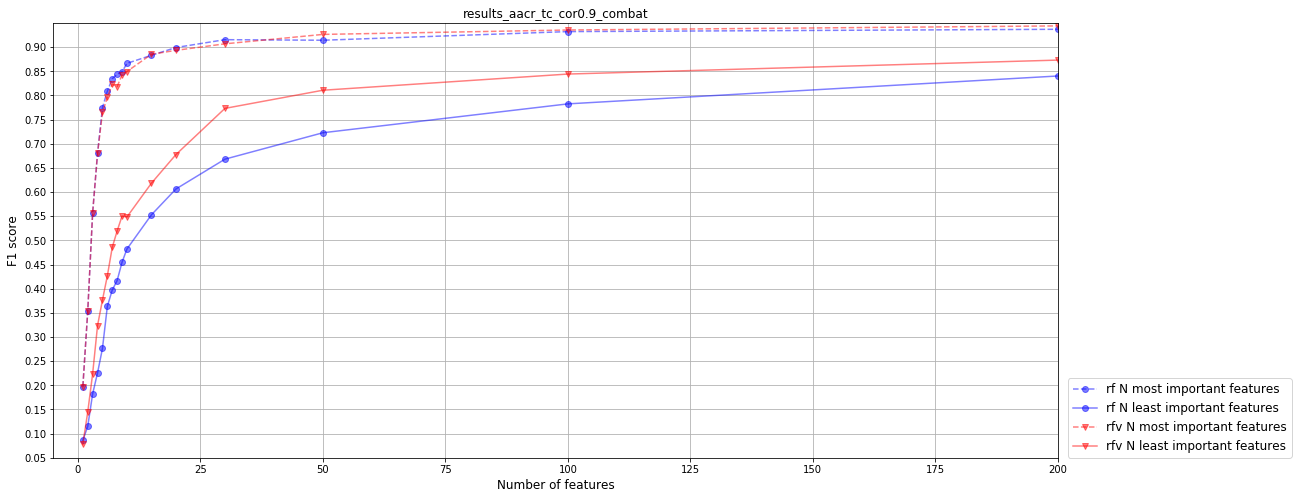

In [18]:
fontsize = 12
fig, ax = plt.subplots(figsize=(18, 8))

ax.plot(rf_acc['ncols'], rf_acc['RF_F1'], 'bo--', alpha=0.5, label='rf N most important features');
ax.plot(rf_acc_inv['ncols'], rf_acc_inv['RF_F1'], 'bo-', alpha=0.5, label='rf N least important features');

# ax.plot(rfs_acc['ncols'], rfs_acc['RF_F1'], 'ks--', alpha=0.5, label='rfs N most important features');
# ax.plot(rfs_acc_inv['ncols'], rfs_acc_inv['RF_F1'], 'ms--', alpha=0.5, label='rfs N least important features');

ax.plot(rfv_acc['ncols'], rfv_acc['RF_F1'], 'rv--', alpha=0.5, label='rfv N most important features');
ax.plot(rfv_acc_inv['ncols'], rfv_acc_inv['RF_F1'], 'rv-', alpha=0.5, label='rfv N least important features');

ax.set_title(path)
ax.set_xlabel('Number of features', fontsize=fontsize)
ax.set_ylabel('F1 score', fontsize=fontsize)
ax.grid()
ax.set_yticks(np.arange(0, 0.95, 0.05))
ax.set_ylim([0.05, 0.95])
ax.set_xlim([-5, 200])
# plt.legend(loc='best', prop={'size': legend_font_size});

ax.legend(loc='lower left', bbox_to_anchor=(1.01, 0.0), ncol=1,
          borderaxespad=0, frameon=True, prop={'size': fontsize});